# Topología Aplicada y Computacional: Complejos Simpliciales


#### Alejandro García Castellanos y Diego José Abengózar Vilar 

## Requerimientos

In [1]:
# !pip install -q matplotlib numpy networkx scipy imageio sympy

## Imports y variables globales

In [2]:
from itertools import combinations, chain
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
import matplotlib.colors
import numpy as np
from numpy.linalg import matrix_rank
import imageio
import sympy as sy
import math
import os
from IPython.display import Image, display, Markdown

# variable curvas
t = sy.symbols('t', real=True)

# dpi figuras
DPI = 200

## Métodos auxiliares

In [3]:
def puntosCurvaRuido(curva, t, t0, t1, numPuntos=10, mu=0, sigma=0.1):
    """
    Obtener conjunto discretos de puntos de una curva con ruido.

    curva: list.
    t: t sympy symbol
    t0: float
        Inicio intervalo.
    t1: float
        Final intervalo.
    numPuntos: int. Por defecto 10.
    mu: float. Por defecto 0
        Media para la distribución normal.
    sigma: float. Por defecto 0.1
        Desviación típica para la distribución normal.
    """
    valores = np.linspace(t0, t1, num=numPuntos)
    puntosCurva = np.array([[x.subs(t, v) for x in curva] for v in valores], dtype=np.float64)
    ruido = np.random.normal(mu, sigma, [numPuntos, len(curva)])

    return puntosCurva + ruido

In [4]:
def low(v):
    """
    Cálculo del low de una columna. Devuelve -1 si el vector es nulo.
    
    v: np.array.
    """
    for i in range(len(v)-1, -1, -1):
        if (v[i] == 1):
            return i

    return -1

In [5]:
def pivotar(M, k, m):
    """
    Pivota en el elemento (k,m) intercambiando filas y columnas.

    M: np.array.
    k: int.
    m: int.
    """
    if M[k, m] != 1:
        encontrado = False
        i = k
        j = m + 1
        while not encontrado and i < M.shape[0] and j < M.shape[1]:
            if M[i, j] == 1:
                # Intercambio columnas
                M[:, [m, j]] = M[:, [j, m]]
                # Intercambio filas
                M[[k, i], :] = M[[i, k], :]
                encontrado = True

            j += 1
            if j == M.shape[1]:
                j = m
                i += 1
    else:
        encontrado = True

    return encontrado

In [6]:
def sumaFilZ2(M, i, j):
    """
    Suma: filai + filaj (sobre la j).

    M: np.array.
    i: int.
    j: int.
    """
    M[j, :] = (M[i, :] + M[j, :]) % 2

In [7]:
def sumaColZ2(M, i, j):
    """
    Suma: coli + colj (sobre la j).

    M: np.array.
    i: int.
    j: int.
    """
    M[:, j] = (M[:, i] + M[:, j]) % 2

In [8]:
def normSmithZ2(M):
    """
    Obtener la forma normal de Smith de una matriz con coefs en Z2.

    M: np.array.
    """
    n = 0
    cols = M.shape[1]
    fils = M.shape[0]
    while n < cols and n < fils and pivotar(M, n, n):
        # Recorrer fila
        for j in range(n + 1, cols):
            if M[n, j] == 1:
                sumaColZ2(M, n, j)
        # Recorrer columna
        for i in range(n + 1, fils):
            if M[i, n] == 1:
                sumaFilZ2(M, n, i)
        n += 1

    return M

In [9]:
def powerset(iterable):
    """
    Optiene un chain con todos los subconjuntos del iterable.

    iterable: iterable.
    """
    # "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

In [10]:
def ordCaras(cara):
    """
    Relacion de orden de las caras de una filtracion.

    cara: tuple().
    """
    return (cara[1], len(cara[0]) - 1, cara[0])

In [11]:
def distancia(p1, p2):
    """
    Distancia euclídea entre los puntos p1 y p2.

    p1: list.
    p2: list.
    """
    p1Np = np.array(p1)
    p2Np = np.array(p2)
    return np.sqrt(np.dot(p1Np - p2Np, p1Np - p2Np))

In [12]:
def radioCircunscrita(p1, p2, p3):
    """
    Dados los vertices de un triangulo obtenemos el radio de la cirunferencia circuncentra.

    p1: tuple.
    p2: tuple.
    p3: tuple.
    """
    a = distancia(p1, p2)
    b = distancia(p1, p3)
    c = distancia(p2, p3)

    s = (a + b + c) / 2

    return (a * b * c) / (4 * np.sqrt(s * (s - a) * (s - b) * (s - c)))

In [13]:
def drawVor(puntos):
    """
    Representacion de las celdas de Voronoi de una nube de puntos.

    puntos: np.array.
    """
    vor = Voronoi(puntos)
    voronoi_plot_2d(vor, show_vertices=False, line_width=2,
                    line_colors='blue', line_alpha=0.6)
    plt.plot(puntos[:, 0], puntos[:, 1], 'ko')
    return vor

In [14]:
def delaunay(puntos):
    """
    Generar el triangulacion de Delaunay y su representacion junto a las celdas de Voronoi.

    puntos: np.array.
    """
    drawVor(puntos)

    Del = Delaunay(puntos)
    c = np.ones(len(puntos))
    cmap = matplotlib.colors.ListedColormap("limegreen")
    plt.tripcolor(puntos[:, 0], puntos[:, 1], Del.simplices, c, edgecolor="k", lw=2,
                  cmap=cmap)
    plt.plot(puntos[:, 0], puntos[:, 1], 'ko')
    plt.show()

    return Complejo([tuple(sorted(triangulo)) for triangulo in Del.simplices])

In [15]:
def alfaComplejo(puntos):
    """
    Genera la filtracion de alfa complejos de la triangulacion de Delaunay.

    puntos: np.array.
    """
    Del = delaunay(puntos)
    # Introducimos los 0-simplices
    alfa = Complejo(Del.getCarasN(0))

    # Introducimos los 2-simplices
    traingNuev = ((t, radioCircunscrita(puntos[t[0]], puntos[t[1]], puntos[t[2]]))
                  for t in Del.getCarasN(2))

    for t in traingNuev:
        alfa.setCaras([t[0]], t[1])

    # Introducimos los 1-simplices
    for arista in Del.getCarasN(1):
        # print(arista)
        p1 = puntos[arista[0]]
        p2 = puntos[arista[1]]
        pMedio = ((p2[0] + p1[0]) / 2, (p2[1] + p1[1]) / 2)
        d = distancia(p1, p2) / 2

        pesoTriangMin = -1
        for triang in Del.getCarasN(2):
            # print(arista, triang)
            difTriangArista = set(triang) - set(arista)

            if len(difTriangArista) == 1 and distancia(puntos[difTriangArista.pop()], pMedio) < d:
                pesoTriang = alfa.umbral(triang)
                if pesoTriangMin < 0 or pesoTriang < pesoTriangMin:
                    pesoTriangMin = pesoTriang

        alfa.setCaras([arista], d if pesoTriangMin < 0 else pesoTriangMin)

    return alfa

In [16]:
def plotalpha(puntos, K):
    """
    Representar el alpha complejo del complejo K.

    puntos: np.array.
    K: Complejo.
    """
    dim = K.dim()

    if dim > 1:
        c = np.ones(len(puntos))
        cmap = matplotlib.colors.ListedColormap("limegreen")
        plt.tripcolor(puntos[:, 0], puntos[:, 1], list(K.getCarasN(2)), c, edgecolor="k", lw=2,
                      cmap=cmap)

    plt.plot(puntos[:, 0], puntos[:, 1], 'ko')

    if dim > 0:
        for arista in K.getCarasN(1):
            p1 = puntos[arista[0]]
            p2 = puntos[arista[1]]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k')

In [17]:
def vietorisRips(puntos):
    """
    Calculo del complejo Vietoris Rips de una nube de puntos.

    puntos: np.array.
    """
    nsimplex = Complejo([tuple(range(len(puntos)))])
    VR = Complejo(list(nsimplex.getCarasN(0)))

    for arista in nsimplex.getCarasN(1):
        VR.setCaras([arista], 0.5 * distancia(puntos[arista[0]], puntos[arista[1]]))

    for i in range(2, len(puntos)):
        for simplex in nsimplex.getCarasN(i):
            lista = []

            for arista in combinations(simplex, 2):
                lista.append(0.5 * distancia(puntos[arista[0]], puntos[arista[1]]))
            VR.setCaras([simplex], max(lista))

    return VR

## Clase Complejo Simplicial

In [18]:
class Complejo():
    """Clase del complejo simplicial."""

    def __init__(self, carasMaximales=[]):
        """
        Complejo simplicial abstracto a partir de sus caras maximales.

        carasMaximales: list(tuple). Por defecto [].
        """
        # Concatenamos el los conjuntos obtenidos de cada cara maximal
        self.caras = set()
        for cara in carasMaximales:
            if cara not in self.caras:
                self.caras |= set(tuple(sorted(list(c))) for c in powerset(cara))
        # Quitamos el conjunto vacio
        self.caras -= {()}

        # Añadimos peso
        self.caras = set([(cara, 0.0) for cara in self.caras])

        self.carasOrd = sorted(list(self.caras), key=ordCaras)

        self.bettiNums = [-1 for a in range(self.dim() + 1)]

    def setCaras(self, carasNuevas, peso=0.0):
        """
        Insertar nuevas caras y sus correspondientes subconjuntos con un peso dado.

        carasNuevas: list(tuple).
        peso: float. Por defecto 0.0.
        """
        diffDim = max([len(cara) - 1 for cara in carasNuevas]) - self.dim()
        if diffDim > 0:
            self.bettiNums.extend(-1 for i in range(diffDim))

        for cara in carasNuevas:
            powerCaras = set(tuple(sorted(list(c))) for c in powerset(cara))
            for caraGen in powerCaras:
                if caraGen == tuple():
                    continue

                encontrado = False
                for caraAnt in self.caras:
                    if caraGen == caraAnt[0]:
                        encontrado = True
                        if caraAnt[1] > peso:
                            self.caras -= {caraAnt}
                            self.caras |= {(caraGen, peso)}

                        break

                if not encontrado:
                    self.caras |= {(caraGen, peso)}

        self.carasOrd = sorted(self.caras, key=ordCaras)

    def getCaras(self):
        """Devuelve el conjunto de todas las caras del complejo simplicial."""
        return set([cara[0] for cara in self.caras])

    def getCarasOrd(self):
        """Devuelve el conjunto de las caras ordenadas segun su filtracion."""
        return [cara[0] for cara in self.carasOrd]

    def umbrales(self):
        """Devuelve el conjunto de las umbrales ordenados segun la filtracion."""
        return list(dict.fromkeys([cara[1] for cara in self.carasOrd]))

    def umbral(self, cara):
        """
        Obtiene el umbral de una cara dada.

        cara: tuple.
        """
        index = 0
        encontrado = False
        while index < len(self.carasOrd) and not encontrado:
            encontrado = self.carasOrd[index][0] == cara
            index += int(not encontrado)

        return self.carasOrd[index][1] if encontrado else None

    def dim(self):
        """Devuelve la dimensión del complejo simplicial."""
        return max([len(caras[0]) for caras in self.caras]) - 1 if self.caras != set() else 0

    def getCarasN(self, dimension):
        """
        Devuelve el conjunto de todas las caras de dimension dada.

        dimension: int.
        """
        return set(c for c in self.getCaras() if len(c) == dimension + 1)

    def st(self, v):
        """
        Calcular la estrella del simplice v.

        v: set.
        """
        return set(c for c in self.getCaras() if v.issubset(c))

    def lk(self, v):
        """
        Calcular el de un simplice v.

        v: set.
        """
        # Calculamos la estrella de v
        st = self.st(v)

        # Calculamos la estrella cerrada de v
        st_ = set()
        for cara in st:
            if cara not in st_:
                st_ |= set(powerset(cara))
        # Quitamos el conjunto vacio
        st_ -= {()}

        # Devolvemos el link de v
        return st_ - st

    def compConexas(self):
        """Comprobar la conexion de un complejo simplicial."""
        # Para ello comprobamos que su 1-esqueleto sea conexo
        k1Graph = nx.Graph()
        k1Graph.add_nodes_from([vertice[0] for vertice in self.getCarasN(0)])
        k1Graph.add_edges_from(self.getCarasN(1))
        return nx.number_connected_components(k1Graph)

    def k_esqueleto(self, k):
        """
        Calcular el k-esqueleto de un complejo simplicial.

        k: int.
        """
        return set(c for c in self.getCaras() if len(c) <= k + 1)

    def drawK1(self):
        """Representación gráfica del 1-esqueleto."""
        k1Graph = nx.Graph()
        k1Graph.add_nodes_from([vertice[0] for vertice in self.getCarasN(0)])
        k1Graph.add_edges_from(self.getCarasN(1))
        plt.figure().add_subplot(111)
        nx.draw_networkx(k1Graph, with_labels=True)

    def caractEuler(self):
        """Obtención de la característica de Euler."""
        return sum([(-1)**k * len(self.getCarasN(k)) for k in range(self.dim() + 1)])

    def filtracion(self, a):
        """
        Obtener las caras con peso menor o igual que un valor.

        a: float.
        """
        i = 0
        caras = list()
        while i < len(self.carasOrd) and self.carasOrd[i][1] <= a:
            caras.append(self.carasOrd[i])
            i += 1

        result = Complejo()
        for cara, peso in caras:
            result.setCaras([cara], peso)

        return result

    def borde(self):
        """Funcion borde."""
        d = self.dim()
        return list(chain.from_iterable(combinations(s, d) for s in self.getCarasN(d)))

    def matrizBorde(self, p):
        """
        Calculo de la matriz borde de dimensión dada.

        p: int.
        """
        if p < 0:
            return None

        carasP = sorted(list(self.getCarasN(p)))

        if p == 0:
            m = np.zeros((1, len(carasP)), dtype=int)
        else:
            carasP_1 = sorted(list(self.getCarasN(p - 1)))
            d = self.dim()
            if p == d + 1:
                m = np.zeros((len(carasP_1), 1), dtype=int)
            elif p > d:
                m = None
            else:
                m = np.zeros((len(carasP_1), len(carasP)), dtype=int)
                for j in range(len(carasP)):
                    caraP = set(carasP[j])
                    for i in range(len(carasP_1)):
                        m[i, j] = int(set(carasP_1[i]).issubset(caraP))

        return m

    def matrizBordeGeneralizada(self):
        """Calculo de la matriz borde generalizada."""
        caras = self.getCarasOrd()
        caras1 = caras.copy()

        m = np.zeros((len(caras), len(caras1)), dtype=int)

        for j in range(len(caras)):
            cara = set(caras[j])
            for i in range(len(caras1)):
                m[i, j] = int(len(cara) - len(caras1[i]) == 1 and set(caras1[i]) != cara and set(caras1[i]).issubset(cara))

        return m

    def algoritmoPersistencia(self):
        """Realiza el algoritmo de persistencia sobre la matriz borde generalizada."""
        M = self.matrizBordeGeneralizada()
        lowsArray = [-1 for i in range(len(M))]

        for j in range(len(M)):
            lowsArray[j] = low(M[:, j])
            # Comportamiento do-while
            mismoLow = True
            while mismoLow and lowsArray[j] >= 0:
                mismoLow = False
                for k in range(j-1, -1, -1):
                    if lowsArray[k] == lowsArray[j]:
                        sumaColZ2(M, k, j)
                        mismoLow = True
                        lowsArray[j] = low(M[:, j])
                        break

        return M, lowsArray

    def persistencia(self):
        """Cálculo de los puntos del diagrama de persistencia."""
        _, lowsArray = self.algoritmoPersistencia()
        dgm = list()
        carasVisitadas = []
        for i in range(0, self.dim()):
            dgmi = list()
            numCaras = len(self.getCarasN(i))
            j = 0
            while j < len(lowsArray) and numCaras > 0:
                if j not in carasVisitadas and lowsArray[j] >= 0 and len(self.carasOrd[lowsArray[j]][0]) == i+1:
                    dgmi.append((self.carasOrd[lowsArray[j]][1], self.carasOrd[j][1]))
                    numCaras = numCaras - 1
                    carasVisitadas.append(j)
                    # Marca de que ya se ha muerto su clase de equivalencia
                    lowsArray[lowsArray[j]] = -2

                j = j + 1

            j = 0
            while j < len(lowsArray) and numCaras > 0:
                if j not in carasVisitadas and lowsArray[j] == -1 and len(self.carasOrd[j][0]) == i+1:
                    dgmi.append((self.carasOrd[j][1], math.inf))
                    numCaras = numCaras - 1
                    carasVisitadas.append(j)
                    # Marca de que ya se ha anadido su persistencia
                    lowsArray[j] = -2
                j = j + 1

            dgm.append(dgmi)

        return dgm

    def diagramaPersistencia(self):
        """Representación del diagrama de persistencia."""
        dmg = self.persistencia()
        fig, ax = plt.subplots(dpi=DPI)
        maxDeath = -1
        infinity = list()
        birth = list()
        death = list()
        for i in range(len(dmg)):
            dmgi = dmg[i]
            birthI = np.array([c[0] for c in dmgi if c[1] != math.inf])
            deathI = np.array([c[1] for c in dmgi if c[1] != math.inf])
            infinity.append([c[0] for c in dmgi if c[1] == math.inf])
            maxDeath = max(maxDeath, int(np.amax(deathI))*1.1 + 1)
            birth.append(birthI)
            death.append(deathI)

        for i in range(len(infinity)):
            if infinity[i] != []:
                birth[i] = np.append(birth[i], np.array(infinity[i]))
                death[i] = np.append(death[i], np.array([maxDeath for j in range(len(infinity[i]))]))

            ax.scatter(x=birth[i], y=death[i], alpha=0.90, label=r"$H_{}$".format(i), zorder=10)

        lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
                ]
        ax.set_xlabel("Birth Time")
        ax.set_ylabel("Death Time")
        ax.plot([lims[0], lims[1]], [lims[0], lims[1]], "--",  color=(0.3, 0.3, 0.3), zorder=0)
        ax.plot([lims[0], lims[1]], [maxDeath, maxDeath], "k--", label=r"$\infty$", zorder=0)
        ax.legend()
        ax.set_xlim(lims)
        ax.set_ylim(bottom=lims[0])
        
        if not os.path.exists("persistencia/"):
            os.makedirs("persistencia/")
            
        fig.savefig("persistencia/perDiag.png", dpi=DPI)

    def codigoBarrasPers(self):
        """Representación de la persistencia en formato de código de barras."""
        dmg = self.persistencia()
        fig, ax = plt.subplots(nrows=len(dmg), sharex=True, dpi=DPI)
        ax = ax[::-1]
        maxDeath = -1
        infinity = list()
        birth = list()
        death = list()
        for i in range(len(dmg)):
            dmgi = dmg[i]
            birthI = np.array([c[0] for c in dmgi if c[1] != math.inf])
            deathI = np.array([c[1] for c in dmgi if c[1] != math.inf])
            infinity.append([c[0] for c in dmgi if c[1] == math.inf])
            maxDeath = max(maxDeath, int(np.amax(deathI))*1.1 + 1)
            birth.append(birthI)
            death.append(deathI)

        for i in range(len(infinity)):
            if infinity[i] != []:
                birth[i] = np.append(birth[i], np.array(infinity[i]))
                death[i] = np.append(death[i], np.array([maxDeath for j in range(len(infinity[i]))]))

            # Elimina las parejas que nacen y mueren a la vez
            n = 0
            while n < len(birth[i]):
                if birth[i][n] == death[i][n]:
                    birth[i] = np.delete(birth[i], n)
                    death[i] = np.delete(death[i], n)
                    n = n-1
                n = n+1
            
            diff = death[i] - birth[i]
            # diff[diff<=0] = 0.005 
            ax[i].barh(y=np.arange(len(birth[i])),
                       width=diff,
                       height=0.2,
                       align="center",
                       left=birth[i],
                       label=r"$H_{}$".format(i),
                       color=f"C{i}",
                       linewidth=0)

            ax[i].get_yaxis().set_ticks([])
            ax[i].set_ylabel(r"$H_{}$".format(i), rotation="horizontal")
            ax[i].get_yaxis().set_label_coords(-0.035, 0.5)
            
        ax[-1].set_xlim(left=-maxDeath*0.01)
        
        if not os.path.exists("persistencia/"):
            os.makedirs("persistencia/")
            
        fig.savefig("persistencia/perBarras.png", dpi=DPI)

    def betti(self, p, incremental=False):
        """
        Calculo del número de p de Betti.

        p: int.
        """
        if incremental and self.dim() == 2:
            # Algoritmo incremental
            b = self.allBettis(incremental=True)[p]

        else:
            if p == 0:
                Zp = len(self.getCarasN(0))
            else:
                Mp = normSmithZ2(self.matrizBorde(p))
                Zp = Mp.shape[1] - matrix_rank(Mp)

            Bp = matrix_rank(normSmithZ2(self.matrizBorde(p + 1)))

            b = Zp - Bp

            self.bettiNums[p] = b

        return b

    def allBettis(self, incremental=False):
        """Calculo de todos los números de Betti."""
        if incremental and self.dim() == 2:
            # Puede que el resultado sea erroneo si el complejo no está contenido en R2
            # Algoritmo incremental
            k1Graph = nx.Graph()
            nodos = self.getCarasN(0)
            k1Graph.add_nodes_from([vertice[0] for vertice in nodos])

            self.bettiNums[0] = len(nodos)
            self.bettiNums[1] = 0
            numCompConexas = self.bettiNums[0]

            for arista in self.getCarasN(1):
                k1Graph.add_edge(*arista)
                newNumCompConexas = nx.number_connected_components(k1Graph)
                if nx.number_connected_components(k1Graph) < numCompConexas:
                    numCompConexas = newNumCompConexas
                    self.bettiNums[0] -= 1
                else:
                    self.bettiNums[1] += 1

            self.bettiNums[1] -= len(self.getCarasN(2))
            self.bettiNums[2] = 0

        elif -1 in self.bettiNums:
            # Calculo con las matrices borde
            Zps = np.array([len(self.getCarasN(0))], dtype=int)
            Bps = np.array([], dtype=int)
            d = self.dim()
            for p in range(1, d + 2):
                Mp = normSmithZ2(self.matrizBorde(p))

                if p <= d:
                    Zps = np.append(Zps, Mp.shape[1] - matrix_rank(Mp))

                Bps = np.append(Bps, matrix_rank(Mp))

            self.bettiNums = list(Zps - Bps)

        return self.bettiNums

    def __str__(self):
        """El toString del complejo."""
        return "Caras: " + str(self.caras)

## Ejemplos

### Funciones auxiliares

In [19]:
def analisisComplejo(comp, simplice):
    """
    Alisis de las propiedades del complejo simplicial.

    comp: Complejo.
    simplice: set(tuple)
        simplice como ref para ejemplos.
    """
    # Todas las caras del complejo
    display(Markdown(f"**Todas las caras:** {comp.getCaras()}"))

    # Dimension del complejo
    dimComp = comp.dim()
    display(Markdown(f"**Dimension:** {dimComp}"))

    # Caras de cierta dimension
    for n in range(dimComp + 1):
        display(Markdown(f"**Todas las caras de dim {n}:** {comp.getCarasN(n)}"))

    # Característica de Euler
    display(Markdown(f"**Característica de Euler:** {comp.caractEuler()}"))

    # Estrella
    display(Markdown(f"**Estrella de {simplice}:** {comp.st(simplice)}"))

    # Link
    display(Markdown(f"**Link de {simplice}:** {comp.lk(simplice)}"))

    # Componentes conexas
    display(Markdown(f"**Numero de componentes conexas:** {comp.compConexas()}"))

    # 1-esqueleto
    display(Markdown(f"**El 1-esqueleto es:** {comp.k_esqueleto(1)}"))

In [20]:
def dibujarAlfaComplejos(alfaComplejo, voronoi):
    """
    Dibuja la filtración de un alfa complejo sobre el diagrama de Voronoi.
    
    alfaComplejo: Complejo.
    voronoi: scipy.spatial.qhull.Voronoi
    """
    i = 0
    images = []
    if not os.path.exists("imgTemp/"):
        os.makedirs("imgTemp/")
            
    for valor in alpha.umbrales():
        K = alpha.filtracion(valor)
        fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, line_colors='blue', lines_alpha=0.6)
        plotalpha(points, K)
        plt.title(r"$r={}$".format(str(valor)))
        fig.savefig(f"imgTemp/im{i}.png", dpi=DPI)
        images.append(imageio.imread(f"imgTemp/im{i}.png"))
        i += 1
        plt.show()

    if not os.path.exists("alphaGif/"):
        os.makedirs("alphaGif/")
    imageio.mimsave('alphaGif/alpha.gif', images)

### Ejemplos Práctica 1

### Tetraedro

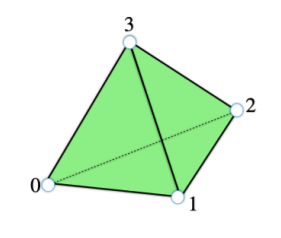

In [21]:
comp1 = Complejo([(0, 1, 2, 3)])
analisisComplejo(comp1, set((0, 1)))

**Todas las caras:** {(0, 1), (1, 2), (1, 3), (0,), (1,), (0, 1, 2), (2,), (0, 2, 3), (3,), (1, 2, 3), (0, 1, 3), (2, 3), (0, 3), (0, 2), (0, 1, 2, 3)}

**Dimension:** 3

**Todas las caras de dim 0:** {(2,), (0,), (3,), (1,)}

**Todas las caras de dim 1:** {(0, 1), (1, 2), (1, 3), (2, 3), (0, 3), (0, 2)}

**Todas las caras de dim 2:** {(0, 1, 2), (0, 2, 3), (0, 1, 3), (1, 2, 3)}

**Todas las caras de dim 3:** {(0, 1, 2, 3)}

**Característica de Euler:** 1

**Estrella de {0, 1}:** {(0, 1), (0, 1, 2, 3), (0, 1, 2), (0, 1, 3)}

**Link de {0, 1}:** {(1, 2), (1, 3), (0,), (1,), (0, 2, 3), (2,), (3,), (1, 2, 3), (2, 3), (0, 3), (0, 2)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(0, 1), (1, 2), (1, 3), (0,), (1,), (2,), (3,), (2, 3), (0, 3), (0, 2)}

### 2-esqueleto del tetraedro (borde del tetraedro)

In [22]:
comp2 = Complejo(list(comp1.k_esqueleto(2)))
analisisComplejo(comp2, set((0,)))

**Todas las caras:** {(0, 1), (1, 2), (1, 3), (0,), (1,), (0, 1, 2), (2,), (0, 2, 3), (3,), (1, 2, 3), (0, 1, 3), (2, 3), (0, 3), (0, 2)}

**Dimension:** 2

**Todas las caras de dim 0:** {(2,), (0,), (3,), (1,)}

**Todas las caras de dim 1:** {(0, 1), (1, 2), (1, 3), (2, 3), (0, 3), (0, 2)}

**Todas las caras de dim 2:** {(0, 1, 2), (0, 2, 3), (0, 1, 3), (1, 2, 3)}

**Característica de Euler:** 2

**Estrella de {0}:** {(0, 1), (0,), (0, 2, 3), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2)}

**Link de {0}:** {(1, 2), (1, 3), (1,), (2,), (3,), (2, 3)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(0, 1), (1, 2), (1, 3), (0,), (1,), (2,), (3,), (2, 3), (0, 3), (0, 2)}

### Ejemplo 3

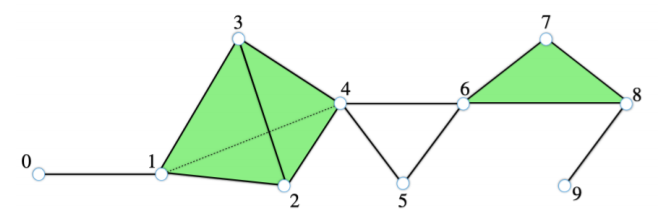

In [23]:
comp3 = Complejo([(0, 1), (1, 2, 3, 4), (4, 5), (5, 6), (4, 6), (6, 7, 8), (8, 9)])
analisisComplejo(comp3, set((4,)))

**Todas las caras:** {(1, 3), (5, 6), (9,), (8, 9), (1, 2), (6, 7), (1,), (3,), (5,), (7,), (3, 4), (4, 5), (8,), (1, 4), (6, 7, 8), (1, 2, 3), (2, 3), (1, 2, 4), (0, 1), (0,), (1, 2, 3, 4), (4, 6), (6, 8), (2,), (4,), (6,), (1, 3, 4), (2, 3, 4), (7, 8), (2, 4)}

**Dimension:** 3

**Todas las caras de dim 0:** {(0,), (1,), (2,), (8,), (3,), (9,), (4,), (5,), (6,), (7,)}

**Todas las caras de dim 1:** {(1, 2), (0, 1), (7, 8), (1, 3), (6, 7), (4, 6), (6, 8), (5, 6), (4, 5), (1, 4), (8, 9), (2, 3), (3, 4), (2, 4)}

**Todas las caras de dim 2:** {(6, 7, 8), (1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)}

**Todas las caras de dim 3:** {(1, 2, 3, 4)}

**Característica de Euler:** 0

**Estrella de {4}:** {(1, 2, 3, 4), (4, 6), (4, 5), (1, 4), (4,), (1, 2, 4), (1, 3, 4), (2, 3, 4), (3, 4), (2, 4)}

**Link de {4}:** {(1, 2), (1, 3), (1,), (2,), (3,), (1, 2, 3), (5,), (2, 3), (6,)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(1, 3), (5, 6), (9,), (8, 9), (1, 2), (6, 7), (1,), (3,), (5,), (7,), (4, 5), (8,), (1, 4), (2, 3), (0, 1), (7, 8), (0,), (4, 6), (6, 8), (2,), (4,), (6,), (3, 4), (2, 4)}

### 1-esqueleto de Ejemplo 3

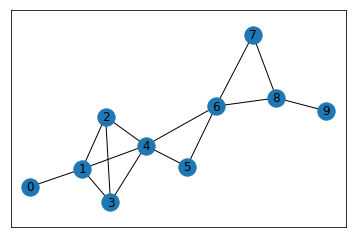

In [24]:
comp3.drawK1()

In [25]:
comp4 = Complejo(list(comp3.k_esqueleto(1)))
analisisComplejo(comp4, set((4,)))

**Todas las caras:** {(1, 3), (5, 6), (9,), (8, 9), (1, 2), (6, 7), (1,), (3,), (5,), (7,), (3, 4), (4, 5), (8,), (1, 4), (2, 3), (0, 1), (0,), (4, 6), (6, 8), (2,), (4,), (6,), (7, 8), (2, 4)}

**Dimension:** 1

**Todas las caras de dim 0:** {(0,), (1,), (2,), (8,), (3,), (9,), (4,), (5,), (6,), (7,)}

**Todas las caras de dim 1:** {(1, 2), (0, 1), (7, 8), (1, 3), (6, 7), (4, 6), (6, 8), (5, 6), (4, 5), (1, 4), (8, 9), (2, 3), (3, 4), (2, 4)}

**Característica de Euler:** -4

**Estrella de {4}:** {(4, 6), (4, 5), (1, 4), (4,), (3, 4), (2, 4)}

**Link de {4}:** {(1,), (2,), (3,), (5,), (6,)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(1, 3), (5, 6), (9,), (8, 9), (1, 2), (6, 7), (1,), (3,), (5,), (7,), (4, 5), (8,), (1, 4), (2, 3), (0, 1), (7, 8), (0,), (4, 6), (6, 8), (2,), (4,), (6,), (3, 4), (2, 4)}

### Ejemplo 5

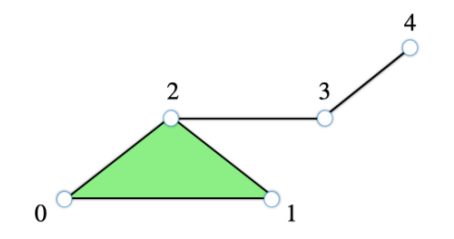

In [26]:
comp5 = Complejo([(0, 1, 2), (2, 3), (3, 4)])
analisisComplejo(comp5, set((2,)))

**Todas las caras:** {(0, 1), (1, 2), (0,), (1,), (0, 1, 2), (2,), (3,), (4,), (2, 3), (3, 4), (0, 2)}

**Dimension:** 2

**Todas las caras de dim 0:** {(0,), (1,), (2,), (3,), (4,)}

**Todas las caras de dim 1:** {(0, 1), (1, 2), (2, 3), (3, 4), (0, 2)}

**Todas las caras de dim 2:** {(0, 1, 2)}

**Característica de Euler:** 1

**Estrella de {2}:** {(1, 2), (0, 1, 2), (2,), (2, 3), (0, 2)}

**Link de {2}:** {(0, 1), (0,), (3,), (1,)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(0, 1), (1, 2), (0,), (1,), (2,), (3,), (4,), (2, 3), (3, 4), (0, 2)}

### Triangulación del anillo cerrado

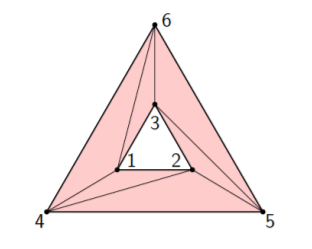

In [27]:
comp6 = Complejo([(1, 2, 4), (1, 3, 6), (1, 4, 6), (2, 3, 5), (2, 4, 5), (3, 5, 6)])
analisisComplejo(comp6, set((1, 4)))

**Todas las caras:** {(2, 3, 5), (1, 3), (5, 6), (1, 6), (2, 5), (1, 2), (1,), (3,), (5,), (2, 4, 5), (3, 6), (4, 5), (1, 4), (2, 3), (1, 2, 4), (3, 5), (4, 6), (2,), (1, 3, 6), (4,), (6,), (3, 5, 6), (1, 4, 6), (2, 4)}

**Dimension:** 2

**Todas las caras de dim 0:** {(1,), (2,), (3,), (4,), (5,), (6,)}

**Todas las caras de dim 1:** {(1, 2), (1, 3), (4, 6), (5, 6), (4, 5), (1, 4), (1, 6), (2, 3), (3, 6), (2, 5), (2, 4), (3, 5)}

**Todas las caras de dim 2:** {(2, 3, 5), (1, 3, 6), (3, 5, 6), (1, 2, 4), (2, 4, 5), (1, 4, 6)}

**Característica de Euler:** 0

**Estrella de {1, 4}:** {(1, 2, 4), (1, 4, 6), (1, 4)}

**Link de {1, 4}:** {(1, 2), (4, 6), (1,), (2,), (4,), (1, 6), (6,), (2, 4)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(1, 2), (1, 3), (4, 6), (1,), (5, 6), (4, 5), (2,), (3,), (1, 4), (4,), (5,), (1, 6), (2, 3), (3, 6), (6,), (2, 5), (2, 4), (3, 5)}

### 1-esqueleto de la triangulación del anillo cerrado

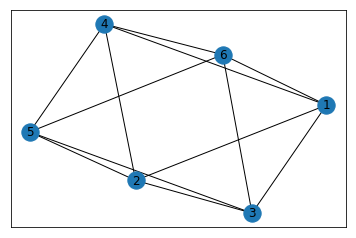

In [28]:
comp6.drawK1()

In [29]:
comp7 = Complejo(list(comp6.k_esqueleto(1)))
analisisComplejo(comp7, set((1, 4)))

**Todas las caras:** {(1, 2), (1, 3), (4, 6), (1,), (4, 5), (2,), (5, 6), (3,), (1, 4), (4,), (5,), (1, 6), (6,), (2, 3), (3, 6), (2, 5), (2, 4), (3, 5)}

**Dimension:** 1

**Todas las caras de dim 0:** {(1,), (2,), (3,), (4,), (5,), (6,)}

**Todas las caras de dim 1:** {(1, 2), (1, 3), (4, 6), (5, 6), (4, 5), (1, 4), (1, 6), (2, 3), (3, 6), (2, 5), (2, 4), (3, 5)}

**Característica de Euler:** -6

**Estrella de {1, 4}:** {(1, 4)}

**Link de {1, 4}:** {(1,), (4,)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(1, 2), (1, 3), (4, 6), (1,), (4, 5), (2,), (5, 6), (3,), (1, 4), (4,), (5,), (1, 6), (6,), (2, 3), (3, 6), (2, 5), (2, 4), (3, 5)}

### Triangulación del toro

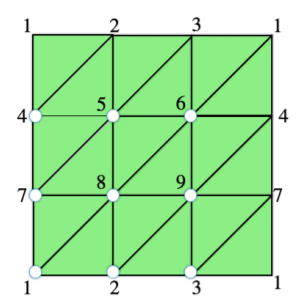

In [30]:
comp8 = Complejo([(1, 2, 4), (2, 4, 5), (2, 3, 5), (3, 5, 6), (1, 3, 6), (1, 4, 6),
                  (4, 5, 7), (5, 7, 8), (5, 6, 8), (6, 8, 9), (4, 6, 9), (4, 7, 9),
                  (1, 7, 8), (1, 2, 8), (2, 8, 9), (2, 3, 9), (3, 7, 9), (1, 3, 7)])
analisisComplejo(comp8, set((1,)))

**Todas las caras:** {(2, 3, 5), (4, 7), (1, 3), (1, 2, 8), (6, 9), (5, 6), (2, 8), (4, 6, 9), (6, 8, 9), (9,), (8, 9), (5, 7, 8), (1, 6), (3, 7), (2, 5), (5, 8), (1, 2), (1, 7, 8), (4, 9), (1,), (2, 9), (5, 6, 8), (3,), (5,), (2, 8, 9), (3, 6), (7,), (2, 4, 5), (4, 7, 9), (4, 5), (8,), (1, 4), (3, 9), (2, 3), (1, 2, 4), (7, 9), (3, 5), (1, 3, 7), (4, 5, 7), (4, 6), (6, 8), (2, 3, 9), (3, 7, 9), (2,), (1, 3, 6), (5, 7), (4,), (1, 8), (6,), (3, 5, 6), (1, 7), (1, 4, 6), (7, 8), (2, 4)}

**Dimension:** 2

**Todas las caras de dim 0:** {(1,), (2,), (8,), (3,), (9,), (4,), (5,), (6,), (7,)}

**Todas las caras de dim 1:** {(6, 9), (4, 7), (1, 3), (5, 6), (2, 8), (8, 9), (1, 6), (3, 7), (2, 5), (5, 8), (1, 2), (4, 9), (2, 9), (3, 6), (4, 5), (1, 4), (3, 9), (2, 3), (7, 9), (3, 5), (4, 6), (6, 8), (5, 7), (1, 8), (1, 7), (7, 8), (2, 4)}

**Todas las caras de dim 2:** {(2, 3, 5), (1, 2, 8), (1, 3, 7), (4, 5, 7), (2, 3, 9), (3, 7, 9), (1, 3, 6), (6, 8, 9), (4, 6, 9), (5, 6, 8), (5, 7, 8), (3, 5, 6), (2, 8, 9), (1, 7, 8), (2, 4, 5), (1, 2, 4), (1, 4, 6), (4, 7, 9)}

**Característica de Euler:** 0

**Estrella de {1}:** {(1, 2), (1, 2, 8), (1, 3), (1, 3, 7), (1,), (1, 3, 6), (1, 4), (1, 8), (1, 6), (1, 2, 4), (1, 7, 8), (1, 4, 6), (1, 7)}

**Link de {1}:** {(4, 6), (2, 8), (2,), (8,), (3,), (4,), (6,), (3, 6), (7,), (3, 7), (7, 8), (2, 4)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(6, 9), (4, 7), (1, 3), (5, 6), (2, 8), (9,), (8, 9), (1, 6), (3, 7), (2, 5), (5, 8), (1, 2), (4, 9), (1,), (2, 9), (3,), (5,), (3, 6), (7,), (4, 5), (8,), (1, 4), (3, 9), (2, 3), (7, 9), (3, 5), (4, 6), (6, 8), (2,), (5, 7), (4,), (1, 8), (6,), (1, 7), (7, 8), (2, 4)}

### 1-esqueleto de la triangulación del toro

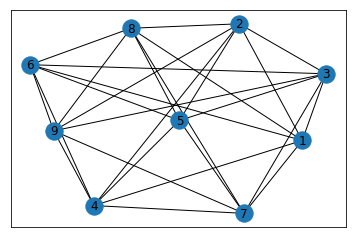

In [31]:
comp8.drawK1()

In [32]:
comp9 = Complejo(list(comp8.k_esqueleto(1)))
analisisComplejo(comp9, set((1,)))

**Todas las caras:** {(4, 7), (1, 3), (6, 9), (5, 6), (2, 8), (9,), (8, 9), (1, 6), (3, 7), (2, 5), (5, 8), (1, 2), (4, 9), (1,), (2, 9), (3,), (5,), (3, 6), (7,), (4, 5), (8,), (1, 4), (3, 9), (2, 3), (3, 5), (7, 9), (4, 6), (6, 8), (2,), (5, 7), (4,), (1, 8), (6,), (1, 7), (7, 8), (2, 4)}

**Dimension:** 1

**Todas las caras de dim 0:** {(1,), (2,), (8,), (3,), (9,), (4,), (5,), (6,), (7,)}

**Todas las caras de dim 1:** {(6, 9), (4, 7), (1, 3), (5, 6), (2, 8), (8, 9), (1, 6), (3, 7), (2, 5), (5, 8), (1, 2), (4, 9), (2, 9), (3, 6), (4, 5), (1, 4), (3, 9), (2, 3), (3, 5), (7, 9), (4, 6), (6, 8), (5, 7), (1, 8), (1, 7), (7, 8), (2, 4)}

**Característica de Euler:** -18

**Estrella de {1}:** {(1, 2), (1, 3), (1,), (1, 4), (1, 8), (1, 6), (1, 7)}

**Link de {1}:** {(2,), (8,), (3,), (4,), (6,), (7,)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(6, 9), (4, 7), (1, 3), (5, 6), (2, 8), (9,), (8, 9), (1, 6), (3, 7), (2, 5), (5, 8), (1, 2), (4, 9), (1,), (2, 9), (3,), (5,), (3, 6), (7,), (4, 5), (8,), (1, 4), (3, 9), (2, 3), (3, 5), (7, 9), (4, 6), (6, 8), (2,), (5, 7), (4,), (1, 8), (6,), (1, 7), (7, 8), (2, 4)}

### Triangulación plano proyectivo

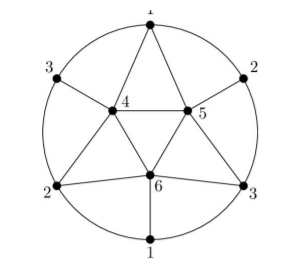

In [33]:
comp10 = Complejo([(1, 2, 6), (2, 3, 4), (1, 3, 4), (1, 2, 5), (2, 3, 5), (1, 3, 6),
                       (2, 4, 6), (1, 4, 5), (3, 5, 6), (4, 5, 6)])
analisisComplejo(comp10, set((1,)))

**Todas las caras:** {(2, 3, 5), (1, 3), (5, 6), (1, 4, 5), (1, 6), (2, 5), (1, 2), (1,), (3,), (1, 5), (5,), (3, 6), (2, 6), (4, 5), (2, 4, 6), (1, 4), (2, 3), (4, 5, 6), (1, 2, 5), (3, 5), (1, 2, 6), (4, 6), (2,), (1, 3, 6), (4,), (6,), (3, 5, 6), (1, 3, 4), (2, 3, 4), (3, 4), (2, 4)}

**Dimension:** 2

**Todas las caras de dim 0:** {(1,), (2,), (3,), (4,), (5,), (6,)}

**Todas las caras de dim 1:** {(1, 2), (1, 3), (2, 6), (4, 6), (5, 6), (4, 5), (1, 4), (1, 5), (1, 6), (2, 3), (3, 6), (2, 5), (3, 4), (2, 4), (3, 5)}

**Todas las caras de dim 2:** {(2, 3, 5), (1, 2, 6), (1, 3, 6), (2, 4, 6), (1, 4, 5), (3, 5, 6), (1, 3, 4), (2, 3, 4), (4, 5, 6), (1, 2, 5)}

**Característica de Euler:** 1

**Estrella de {1}:** {(1, 2), (1, 3), (1, 2, 6), (1,), (1, 3, 6), (1, 4), (1, 4, 5), (1, 5), (1, 6), (1, 3, 4), (1, 2, 5)}

**Link de {1}:** {(2, 6), (4, 5), (2,), (3,), (4,), (5,), (6,), (3, 6), (2, 5), (3, 4)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(1, 3), (5, 6), (1, 6), (2, 5), (1, 2), (1,), (3,), (1, 5), (5,), (3, 6), (2, 6), (4, 5), (1, 4), (2, 3), (3, 5), (4, 6), (2,), (4,), (6,), (3, 4), (2, 4)}

### 1-esqueleto de la triangulación del plano proyectivo

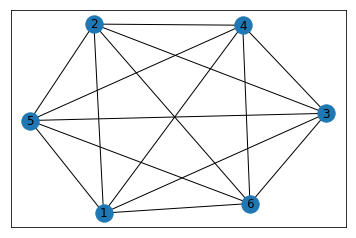

In [34]:
comp10.drawK1()

In [35]:
comp11 = Complejo(list(comp10.k_esqueleto(1)))
analisisComplejo(comp11, set((1,)))

**Todas las caras:** {(1, 3), (5, 6), (1, 6), (2, 5), (1, 2), (1,), (3,), (1, 5), (5,), (3, 6), (2, 6), (4, 5), (1, 4), (2, 3), (3, 5), (4, 6), (2,), (4,), (6,), (3, 4), (2, 4)}

**Dimension:** 1

**Todas las caras de dim 0:** {(1,), (2,), (3,), (4,), (5,), (6,)}

**Todas las caras de dim 1:** {(1, 2), (1, 3), (2, 6), (4, 6), (5, 6), (4, 5), (1, 4), (1, 5), (1, 6), (2, 3), (3, 6), (2, 5), (3, 4), (2, 4), (3, 5)}

**Característica de Euler:** -9

**Estrella de {1}:** {(1, 2), (1, 3), (1,), (1, 4), (1, 5), (1, 6)}

**Link de {1}:** {(2,), (3,), (4,), (5,), (6,)}

**Numero de componentes conexas:** 1

**El 1-esqueleto es:** {(1, 3), (5, 6), (1, 6), (2, 5), (1, 2), (1,), (3,), (1, 5), (5,), (3, 6), (2, 6), (4, 5), (1, 4), (2, 3), (3, 5), (4, 6), (2,), (4,), (6,), (3, 4), (2, 4)}

### Ejemplo 12

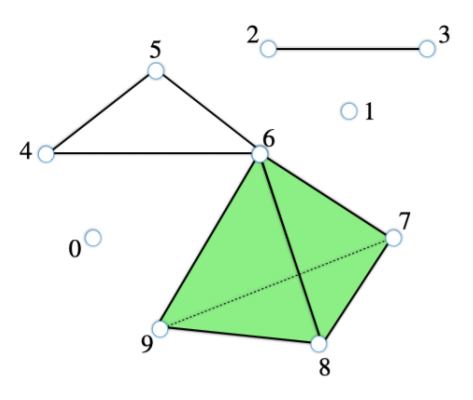

In [36]:
comp12 = Complejo([(0,), (1,), (2, 3), (4, 5), (5, 6), (4, 6), (6, 7, 8, 9)])
analisisComplejo(comp12, set((6,)))

**Todas las caras:** {(6, 9), (5, 6), (6, 8, 9), (9,), (8, 9), (6, 7), (1,), (3,), (5,), (7,), (4, 5), (8,), (7, 8, 9), (6, 7, 8), (2, 3), (6, 7, 9), (7, 9), (0,), (4, 6), (6, 8), (2,), (4,), (6, 7, 8, 9), (6,), (7, 8)}

**Dimension:** 3

**Todas las caras de dim 0:** {(0,), (1,), (2,), (8,), (3,), (9,), (4,), (5,), (6,), (7,)}

**Todas las caras de dim 1:** {(6, 9), (6, 7), (4, 6), (6, 8), (5, 6), (4, 5), (8, 9), (2, 3), (7, 8), (7, 9)}

**Todas las caras de dim 2:** {(6, 7, 9), (6, 8, 9), (7, 8, 9), (6, 7, 8)}

**Todas las caras de dim 3:** {(6, 7, 8, 9)}

**Característica de Euler:** 3

**Estrella de {6}:** {(6, 9), (6, 7), (4, 6), (6, 8), (5, 6), (6, 8, 9), (6, 7, 8), (6, 7, 8, 9), (6, 7, 9), (6,)}

**Link de {6}:** {(8,), (7, 8, 9), (9,), (4,), (8, 9), (5,), (7,), (7, 8), (7, 9)}

**Numero de componentes conexas:** 4

**El 1-esqueleto es:** {(6, 9), (5, 6), (9,), (8, 9), (6, 7), (1,), (3,), (5,), (7,), (4, 5), (8,), (2, 3), (7, 9), (0,), (4, 6), (6, 8), (2,), (4,), (6,), (7, 8)}

### Ejemplo filtraciones en un complejo simplicial

In [37]:
# Ejemplo filtracion
comp13 = Complejo()
comp13.setCaras([(0, 1)], 1.0)
comp13.setCaras([(1, 2), (2, 3), (2, 4)], 2.0)
comp13.setCaras([(3, 4)], 3.0)
comp13.setCaras([(2, 3, 4)], 4.0)

In [38]:
# Todas las caras del complejo
display(Markdown(f"**Todas las caras:** {comp13.getCaras()}"))

**Todas las caras:** {(0, 1), (1, 2), (0,), (1,), (2,), (3,), (4,), (2, 3), (2, 3, 4), (3, 4), (2, 4)}

In [39]:
# Umbral
display(Markdown(f"**Umbral de {{3}}:** {comp13.umbral((3,))}"))

**Umbral de {3}:** 2.0

In [40]:
# Filtraciones
K1 = comp13.filtracion(1.0)
K2 = comp13.filtracion(2.0)
K3 = comp13.filtracion(3.0)
K4 = comp13.filtracion(4.0)

In [41]:
# Todas las caras de las filtraciones
display(Markdown(f"**Todas las caras de K1:** {K1.getCaras()}"))
display(Markdown(f"**Todas las caras de K2:** {K2.getCaras()}"))
display(Markdown(f"**Todas las caras de K3:** {K3.getCaras()}"))
display(Markdown(f"**Todas las caras de K4:** {K4.getCaras()}"))

**Todas las caras de K1:** {(0, 1), (0,), (1,)}

**Todas las caras de K2:** {(0, 1), (1, 2), (0,), (1,), (2,), (3,), (4,), (2, 3), (2, 4)}

**Todas las caras de K3:** {(0, 1), (1, 2), (0,), (1,), (2,), (3,), (4,), (2, 3), (3, 4), (2, 4)}

**Todas las caras de K4:** {(0, 1), (1, 2), (0,), (1,), (2,), (3,), (4,), (2, 3), (2, 3, 4), (3, 4), (2, 4)}

In [42]:
# Caras ordenedas por filtracion
display(Markdown(f"**Caras ordenadas segun las filtraciones:** {comp13.getCarasOrd()}"))

**Caras ordenadas segun las filtraciones:** [(0,), (1,), (0, 1), (2,), (3,), (4,), (1, 2), (2, 3), (2, 4), (3, 4), (2, 3, 4)]

### Ejemplos Práctica 2

#### Nube de puntos

In [43]:
points = np.array([(0.38021546727456423, 0.46419202339598786),
                   (0.7951628297672293, 0.49263630135869474),
                   (0.566623772375203, 0.038325621649018426),
                   (0.3369306814864865, 0.7103735061134965),
                   (0.08272837815822842, 0.2263273314352896),
                   (0.5180166301873989, 0.6271769943824689),
                   (0.33691411899985035, 0.8402045183219995),
                   (0.33244488399729255, 0.4524636520475205),
                   (0.11778991601260325, 0.6657734204021165),
                   (0.9384303415747769, 0.2313873874340855)])

#### Filtración de complejos de Vietoris-Rips 

In [44]:
vr = vietorisRips(points)
vr.carasOrd

[((0,), 0.0),
 ((1,), 0.0),
 ((2,), 0.0),
 ((3,), 0.0),
 ((4,), 0.0),
 ((5,), 0.0),
 ((6,), 0.0),
 ((7,), 0.0),
 ((8,), 0.0),
 ((9,), 0.0),
 ((0, 7), 0.024594630110749274),
 ((3, 6), 0.06491550663246884),
 ((3, 5), 0.09964158316325628),
 ((0, 5), 0.1067160499498478),
 ((3, 8), 0.11181663867459748),
 ((0, 3), 0.12497889333174499),
 ((0, 3, 5), 0.12497889333174499),
 ((5, 7), 0.12743785247513206),
 ((0, 5, 7), 0.12743785247513206),
 ((3, 7), 0.12897443080262758),
 ((0, 3, 7), 0.12897443080262758),
 ((3, 5, 7), 0.12897443080262758),
 ((0, 3, 5, 7), 0.12897443080262758),
 ((5, 6), 0.13980240119025444),
 ((3, 5, 6), 0.13980240119025444),
 ((6, 8), 0.14003715958303004),
 ((3, 6, 8), 0.14003715958303004),
 ((1, 9), 0.14897699064479192),
 ((7, 8), 0.151309131049649),
 ((3, 7, 8), 0.151309131049649),
 ((1, 5), 0.15403831830169779),
 ((0, 8), 0.16545560550649724),
 ((0, 3, 8), 0.16545560550649724),
 ((0, 7, 8), 0.16545560550649724),
 ((0, 3, 7, 8), 0.16545560550649724),
 ((4, 7), 0.1684458138308

#### Diagrama de Voronoi

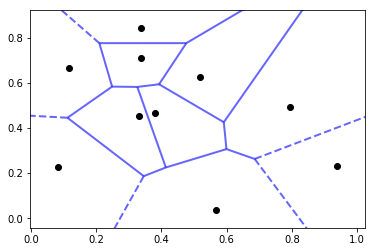

In [45]:
vor = drawVor(points)

#### Triangulación de Delaunay

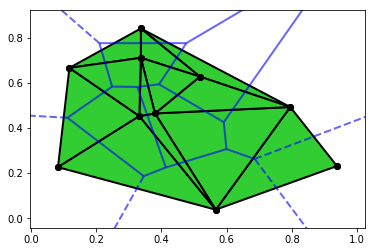

In [46]:
_ = delaunay(points)

#### Alfa compejo

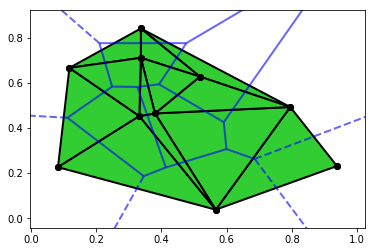

In [47]:
alpha = alfaComplejo(points)

In [ ]:
dibujarAlfaComplejos(alpha, vor)

In [ ]:
Image(filename="alphaGif/alpha.gif")

#### Curva parametrizada y con ruido

In [50]:
curva1 = [4 * sy.sin(t), 9 * sy.cos(t)]
points = puntosCurvaRuido(curva1, t, 0, 2*np.pi, numPuntos=30)

#### Diagrama de Voronoi

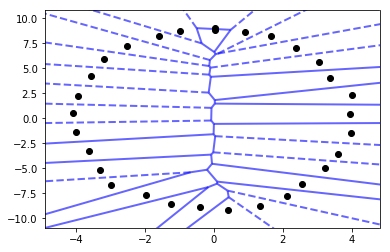

In [51]:
vor = drawVor(points)

#### Triangulación de Delaunay

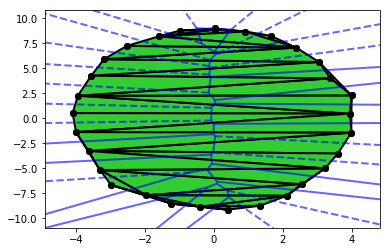

In [52]:
_ = delaunay(points)

#### Alfa Complejo

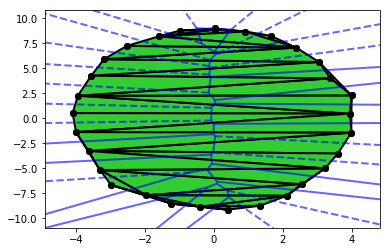

In [53]:
alpha = alfaComplejo(points)

In [ ]:
dibujarAlfaComplejos(alpha, vor)

In [ ]:
Image(filename="alphaGif/alpha.gif")

### Ejemplos Práctica 3

### Tetraedro

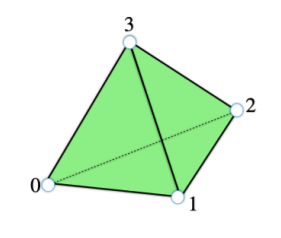

In [56]:
comp1 = Complejo([(0, 1, 2, 3)])
display(Markdown(f"**Los num de Betti del tetraedro son:** {comp1.allBettis()}"))

**Los num de Betti del tetraedro son:** [1, 0, 0, 0]

### Borde del tetraedro

In [57]:
display(Markdown(f"**Los num de Betti del borde del tetraedro son:** {Complejo(comp1.borde()).allBettis()}"))

**Los num de Betti del borde del tetraedro son:** [1, 0, 1]

### Toro

#### Triangulación 1 del toro

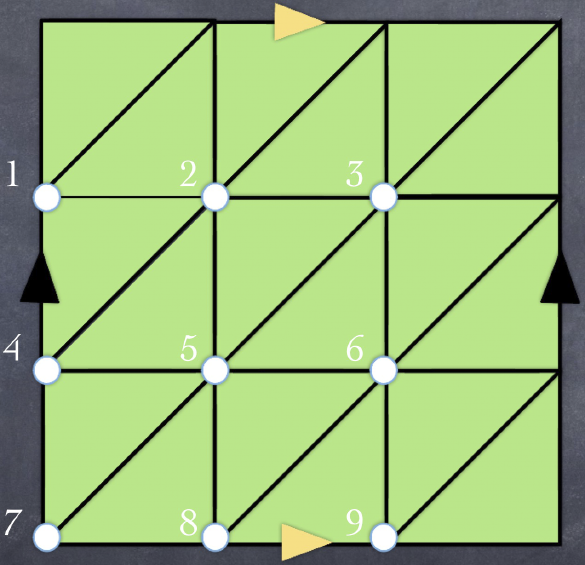

In [58]:
toro1 = Complejo([(1, 7, 8), (1, 2, 8), (2, 8, 9), (2, 3, 9), (3, 9, 7), (3, 1, 7),
                  (4, 1, 2), (4, 5, 2), (5, 2, 3), (5, 6, 3), (6, 3, 1), (6, 4, 1),
                  (7, 4, 5), (7, 8, 5), (8, 5, 6), (8, 9, 6), (9, 6, 4), (9, 7, 4)])
display(Markdown(f"**Los num de Betti del toro son:** {toro1.allBettis()}"))

**Los num de Betti del toro son:** [1, 2, 1]

#### Triangulación minimal del toro

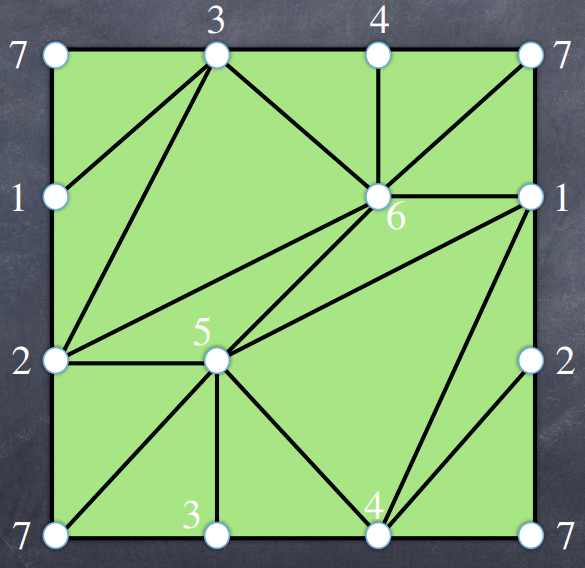

In [59]:
toro2 = Complejo([(1, 7, 3), (3, 4, 6), (6, 4, 7), (1, 2, 3), (2, 3, 6), (6, 7, 1),
                  (2, 5, 6), (5, 6, 1), (7, 2, 5), (7, 3, 5), (3, 4, 5), (5, 4, 1),
                  (1, 4, 2), (2, 4, 7)])
display(Markdown(f"**Los num de Betti del toro con triang minimal son:** {toro2.allBettis()}"))

**Los num de Betti del toro con triang minimal son:** [1, 2, 1]

### Plano proyectivo

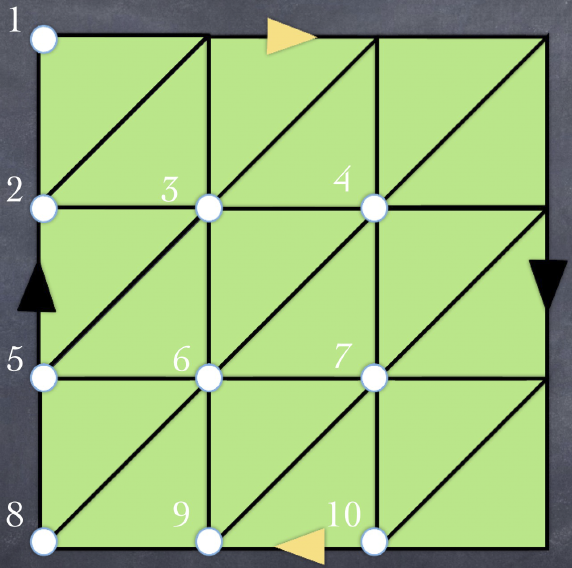

In [60]:
planoProy = Complejo([(1, 2, 10), (2, 3, 10), (3, 9, 10), (3, 4, 9), (4, 8, 9), (4, 5, 8),
                      (2, 3, 5), (3, 5, 6), (3, 6, 4), (4, 6, 7), (4, 5, 7), (2, 5, 7),
                      (5, 6, 8), (6, 8, 9), (6, 7, 9), (7, 9, 10), (2, 7, 10), (1, 2, 10)])
display(Markdown(f"**Los num de Betti del plano proyectivo son:** {planoProy.allBettis()}"))

**Los num de Betti del plano proyectivo son:** [1, 1, 1]

### Botella de Klein

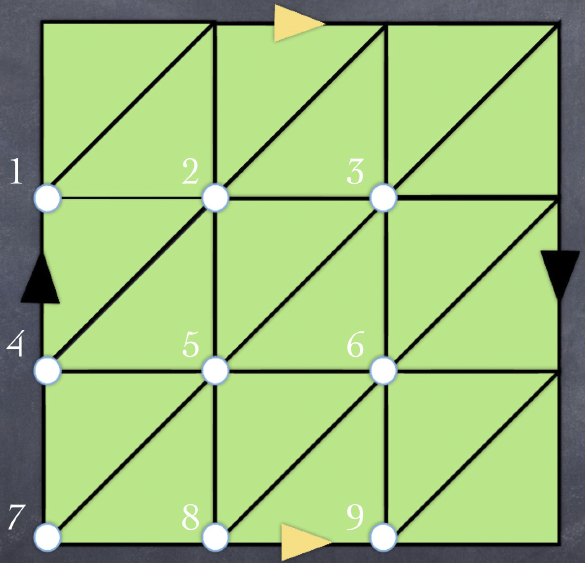

In [61]:
klein = Complejo([(1, 7, 8), (1, 2, 8), (2, 8, 9), (2, 3, 9), (3, 9, 7), (3, 4, 7),
                  (1, 4, 2), (4, 2, 5), (2, 3, 5), (3, 5, 6), (3, 4, 6), (1, 4, 6),
                  (4, 5, 7), (7, 5, 8), (5, 6, 8), (6, 8, 9), (6, 1, 9), (1, 9, 7)])
display(Markdown(f"**Los num de Betti de la botella de Klein son:** {klein.allBettis()}"))

**Los num de Betti de la botella de Klein son:** [1, 2, 1]

### Anillo

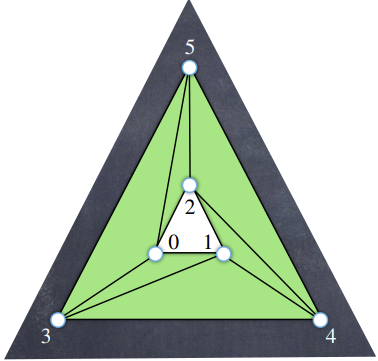

In [62]:
anillo = Complejo([(0, 1, 3), (1, 3, 4), (1, 2, 4), (2, 4, 5), (0, 2, 5), (0, 3, 5)])
display(Markdown(f"**Los num de Betti del anillo son:** {anillo.allBettis()}"))
display(Markdown(f"**Los num de Betti del anillo son (algoritmo incremental):** {anillo.allBettis(incremental=True)}"))

**Los num de Betti del anillo son:** [1, 1, 0]

**Los num de Betti del anillo son (algoritmo incremental):** [1, 1, 0]

### Sombrero del asno

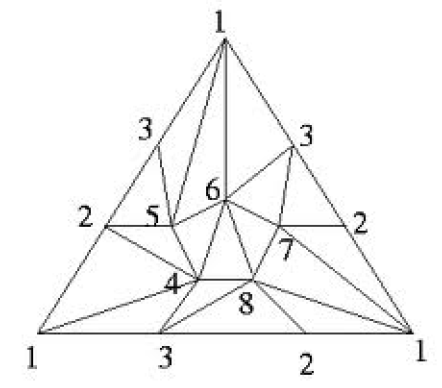
Bolognini, Davide. (2014). Recursive Betti numbers of Cohen-Macaulay balanced clutters arising from posets. Journal of Pure and Applied Algebra. 220. 10.1016/j.jpaa.2016.02.006.

In [63]:
asno = Complejo([(1, 3, 5), (1, 5, 6), (1, 3, 6), (2, 3, 5), (2, 4, 5), (4, 5, 6),
                 (3, 6, 7), (2, 3, 7), (6, 7, 8), (6, 4, 8), (1, 2, 4), (1, 3, 4),
                 (3, 4, 8), (2, 3, 8), (1, 2, 8), (1, 7, 8), (1, 2, 7)])
display(Markdown(f"**Los num de Betti del sombrero del asno son:** {asno.allBettis()}"))
display(Markdown(f"**Los num de Betti del sombrero del asno son (algoritmo incremental):** {asno.allBettis(incremental=True)}"))

**Los num de Betti del sombrero del asno son:** [1, 0, 0]

**Los num de Betti del sombrero del asno son (algoritmo incremental):** [1, 0, 0]

### Doble toro

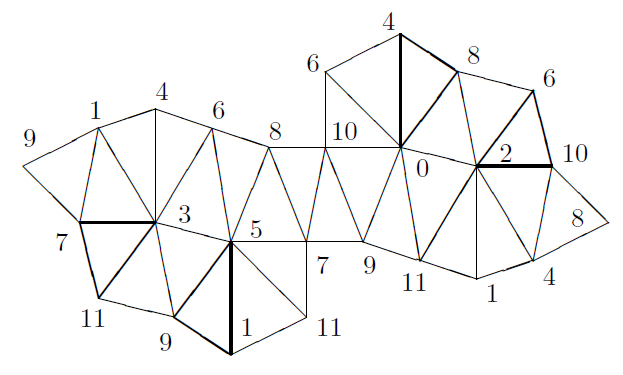
Datta, Basudeb & Upadhyay, Ashish. (2007). Degree-regular triangulations of the double-torus. Forum Mathematicum. 18. 1011-1025. 10.1515/FORUM.2006.051. 

In [64]:
dobeToro = Complejo([(1, 9, 7), (1, 7, 3), (1, 4, 3), (4, 6, 3), (6, 3, 5),
                     (6, 8, 5), (8, 5, 7), (8, 10, 7), (10, 7, 9), (7, 3, 11),
                     (11, 3, 9), (3, 5, 9), (5, 9, 1), (1, 5, 11), (5, 7, 11),
                     (10, 9, 0), (0, 9, 11), (0, 11, 2), (2, 11, 1), (1, 2, 4),
                     (2, 10, 4), (10, 8, 4), (2, 6, 10), (2, 6, 8), (2, 0, 8),
                     (0, 4, 8), (0, 4, 6), (0, 6, 10)])
display(Markdown(f"**Los num de Betti del doble toro son:** {dobeToro.allBettis()}"))

**Los num de Betti del doble toro son:** [1, 4, 1]

### Ejemplo 3

In [65]:
display(Markdown(f"**Los num de Betti del siguiente complejo son:** {comp3.allBettis()}"))

**Los num de Betti del siguiente complejo son:** [1, 1, 0, 0]

### Filtraciónes de alfa complejos

#### Elipse

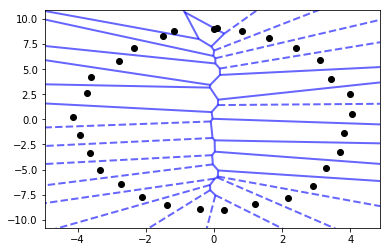

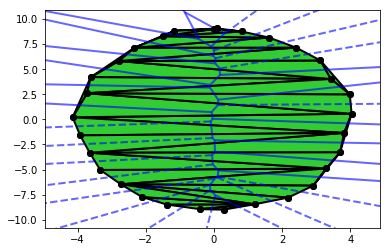

In [66]:
curva1 = [4 * sy.sin(t), 9 * sy.cos(t)]
points = puntosCurvaRuido(curva1, t, 0, 2*np.pi, numPuntos=30)
vor = drawVor(points)
alpha = alfaComplejo(points)
K = alpha.filtracion(3.6)

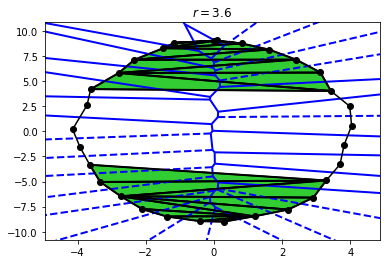

In [67]:
fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, line_colors='blue', lines_alpha=0.6)
plotalpha(points, K)
plt.title(r"$r={}$".format(str(3.6)))
plt.show()

In [68]:
display(Markdown(f"**Los num de Betti del siguiente alpha complejo son:** {K.allBettis()}"))
display(Markdown(f"**Los num de Betti del siguiente alpha complejo son (algoritmo incremental):** {K.allBettis(incremental=True)}"))

**Los num de Betti del siguiente alpha complejo son:** [1, 1, 0]

**Los num de Betti del siguiente alpha complejo son (algoritmo incremental):** [1, 1, 0]

#### Figura ocho

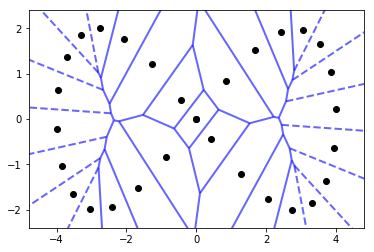

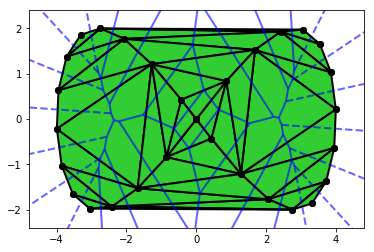

In [69]:
curva2 = [4 * sy.sin(t), 4 * sy.sin(t) * sy.cos(t)]
points = puntosCurvaRuido(curva2, t, 0, 2*np.pi, numPuntos=30, sigma=0.0)
vor = drawVor(points)
alpha = alfaComplejo(points)

In [ ]:
dibujarAlfaComplejos(alpha, vor)

In [ ]:
Image(filename="alphaGif/alpha.gif")

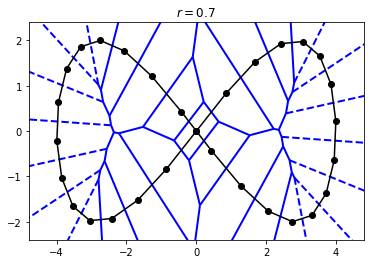

In [72]:
K = alpha.filtracion(0.61)
fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, line_colors='blue', lines_alpha=0.6)
plotalpha(points, K)
plt.title(r"$r={}$".format(str(0.7)))
plt.show()

In [73]:
display(Markdown(f"**Los num de Betti del siguiente alpha complejo son:** {K.allBettis()}"))
display(Markdown(f"**Los num de Betti del siguiente alpha complejo son (algoritmo incremental):** {K.allBettis(incremental=True)}"))

**Los num de Betti del siguiente alpha complejo son:** [1, 2]

**Los num de Betti del siguiente alpha complejo son (algoritmo incremental):** [1, 2]

### Ejemplos Práctica 4

### Persistencia del alfa complejo de una nube de puntos

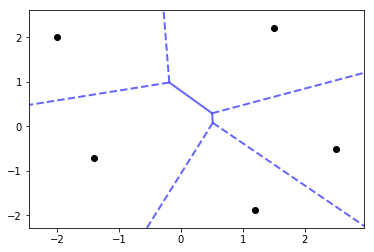

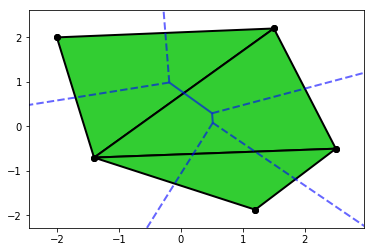

In [74]:
points = np.array([(-2, 2),
                   (1.5, 2.2),
                   (2.5, -0.5),
                   (-1.4, -0.7),
                   (1.2, -1.87)])
vor = drawVor(points)
alpha = alfaComplejo(points)

In [ ]:
dibujarAlfaComplejos(alpha, vor)

#### Diagrama de Persisrencia

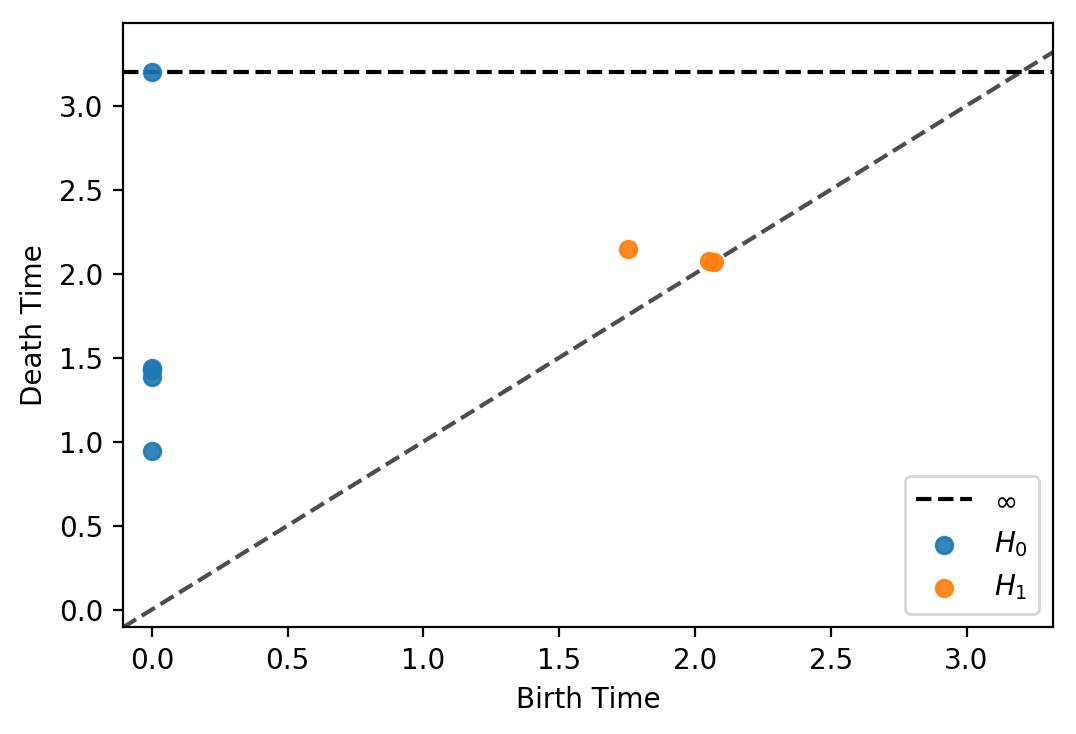

In [76]:
alpha.diagramaPersistencia()

#### Código de barras

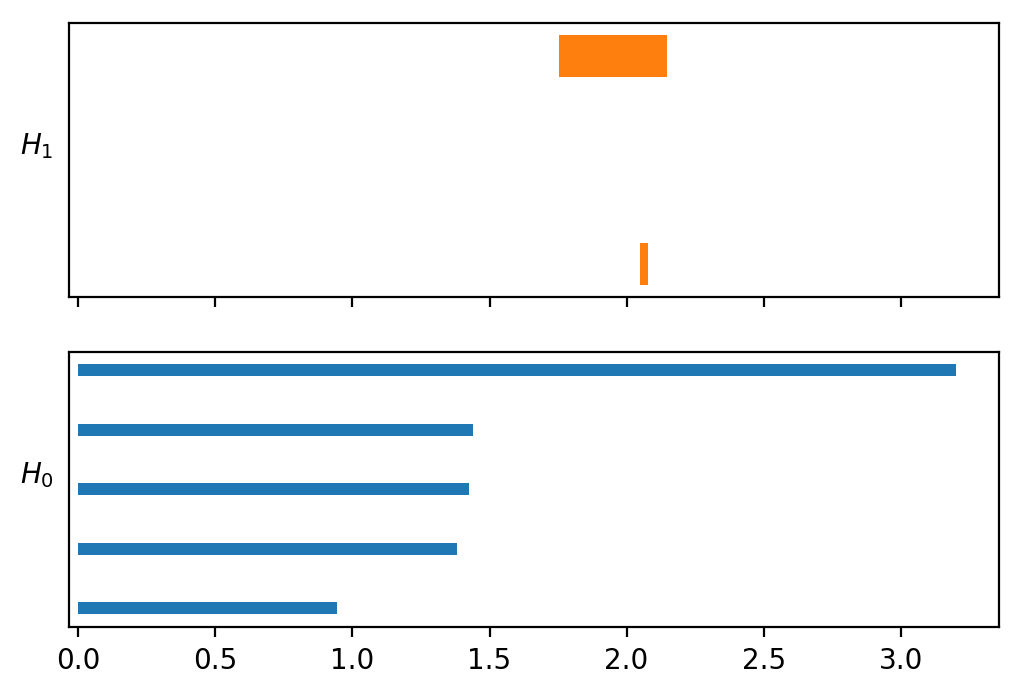

In [77]:
alpha.codigoBarrasPers()

### Persistencia del alfa complejo de la figura ocho

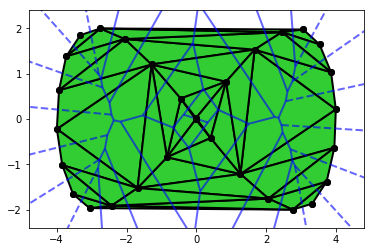

In [78]:
curva2 = [4 * sy.sin(t), 4 * sy.sin(t) * sy.cos(t)]
points = puntosCurvaRuido(curva2, t, 0, 2*np.pi, numPuntos=30, sigma=0.01)
alpha = alfaComplejo(points)

#### Diagrama de Persisrencia

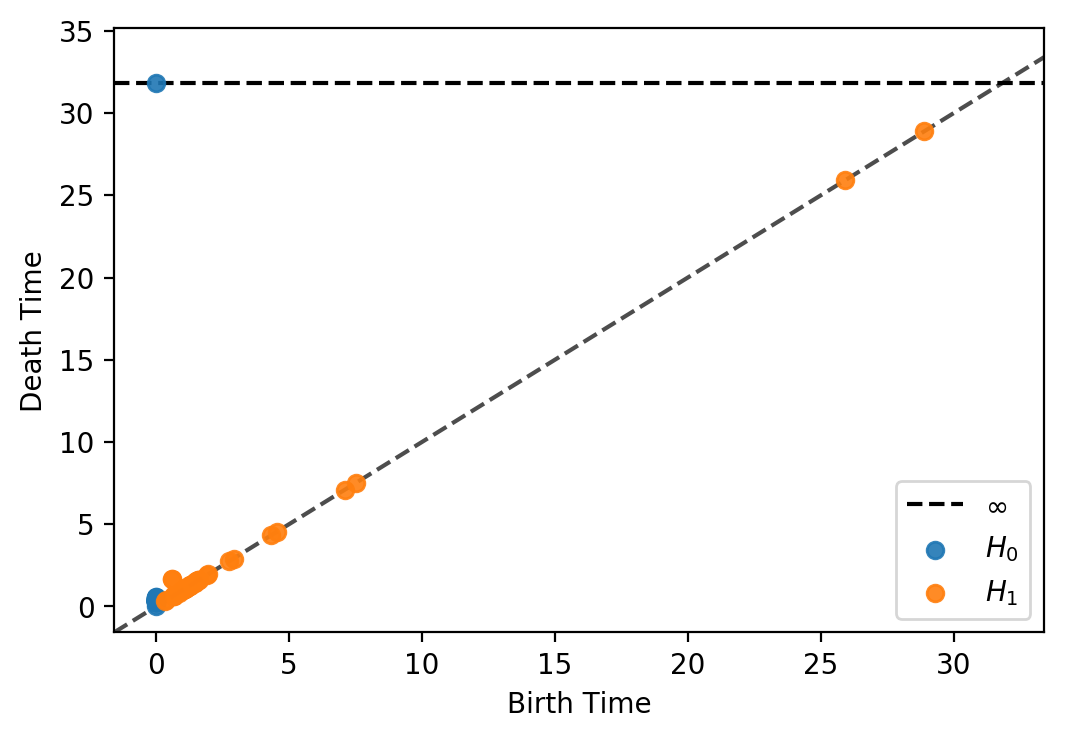

In [79]:
alpha.diagramaPersistencia()

#### Código de barras

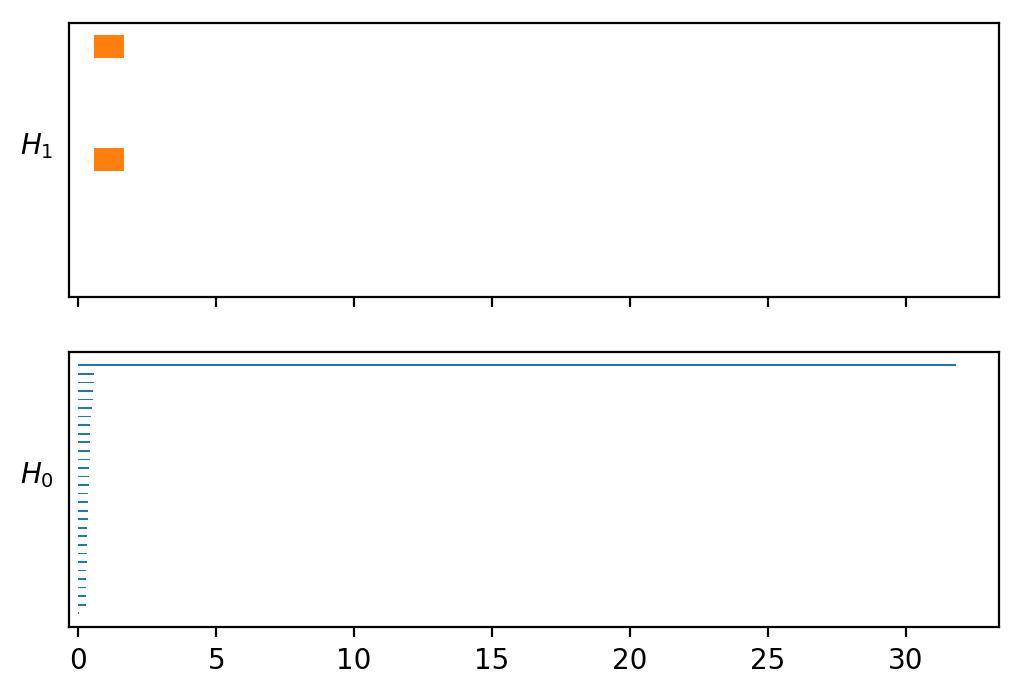

In [80]:
alpha.codigoBarrasPers()

### Persistencia del alfa complejo de la rosa polar

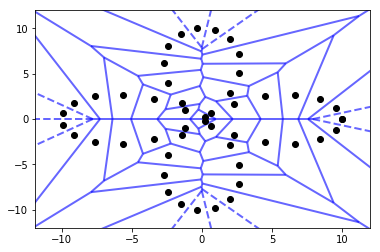

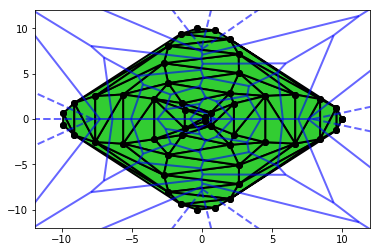

In [81]:
curva2 = [10 * sy.cos(2 * t) * sy.cos(t),
          10 * sy.cos(2 * t) * sy.sin(t)]
points = puntosCurvaRuido(curva2, t, 0, 2*np.pi, numPuntos=50, sigma=0.00)
vor = drawVor(points)
alpha = alfaComplejo(points)

In [ ]:
dibujarAlfaComplejos(alpha, vor)

In [ ]:
Image(filename="alphaGif/alpha.gif")

#### Diagrama de Persisrencia

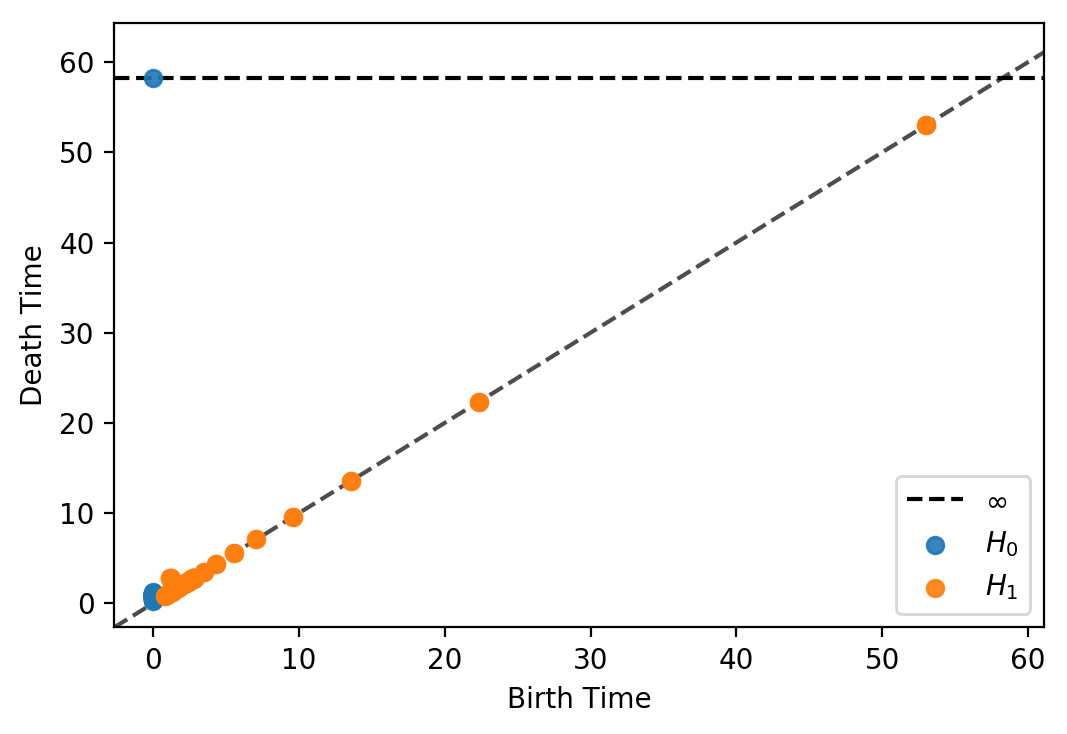

In [84]:
alpha.diagramaPersistencia()

#### Código de barras

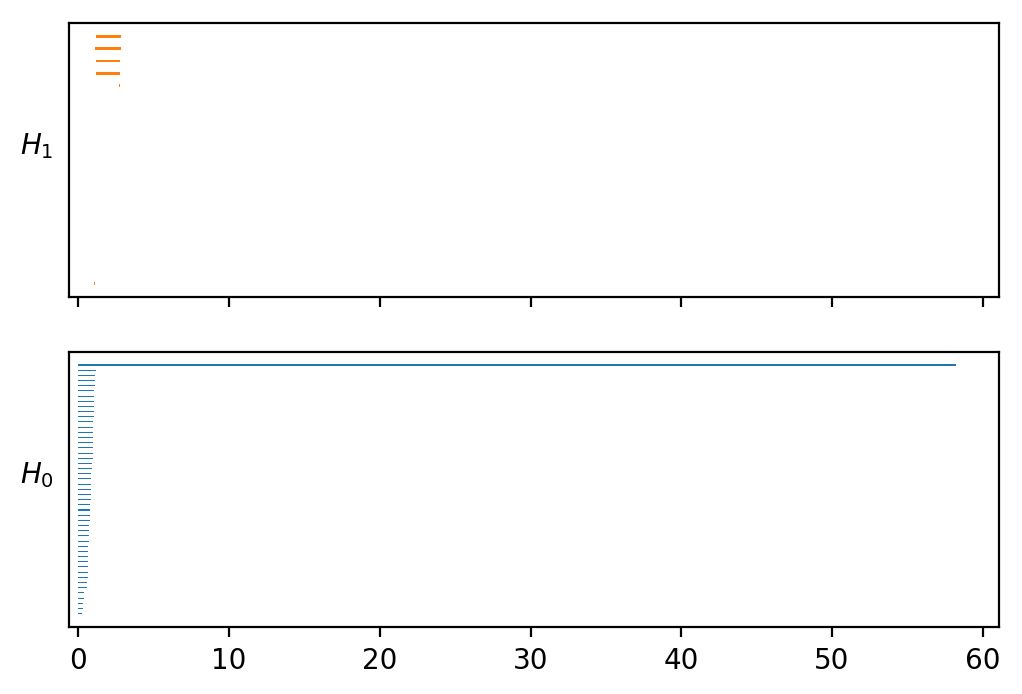

In [85]:
alpha.codigoBarrasPers()